In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [51]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([6, 1, 8, 6, 0, 9, 1, 5, 9, 3]))

In [4]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()
                         ).to(def_device)

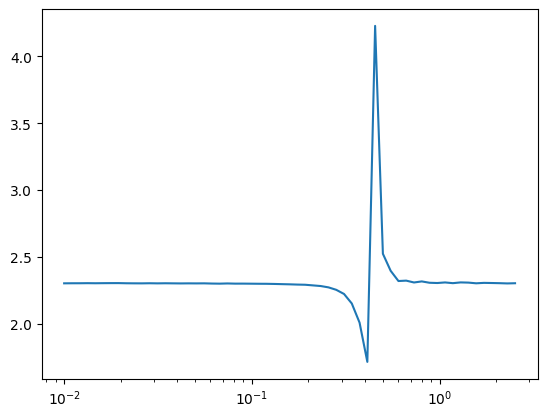

In [24]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2, max_epochs=1)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.122,2.323,0,train
0.100,2.303,0,eval


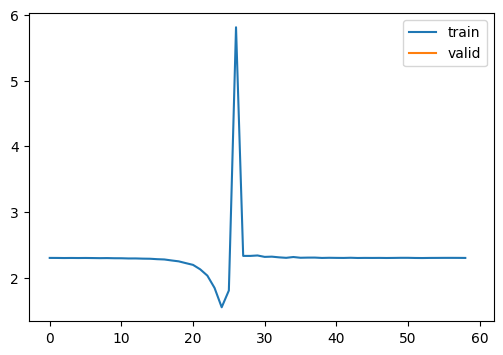

In [26]:
learn.fit(1)

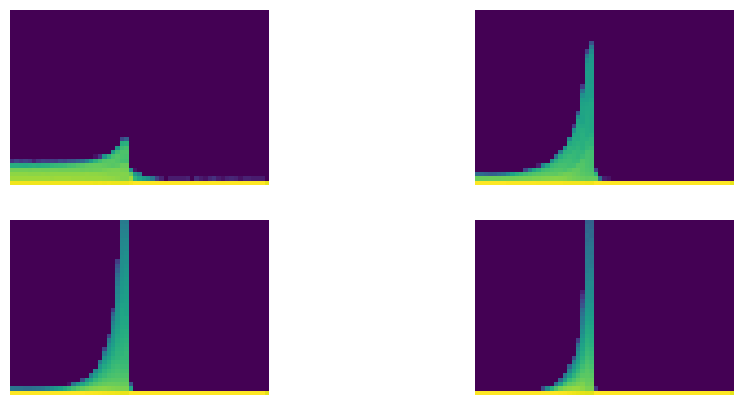

In [27]:
astats.color_dim()

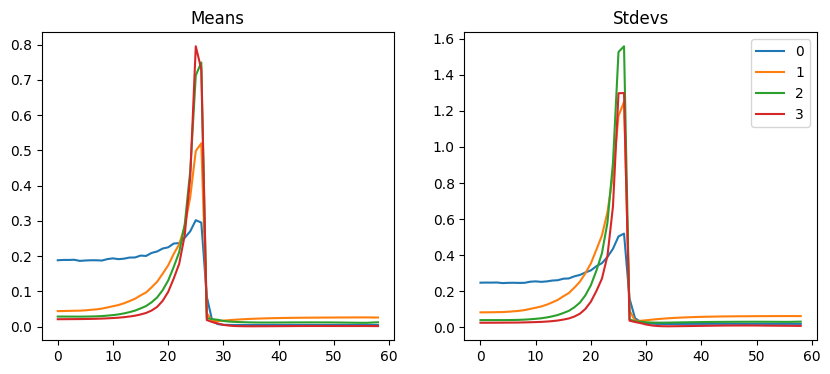

In [28]:
astats.plot_stats()

NB very bad behaviour, and although ends with mean ~0 the stdevs are also around 0! So there's nothing going on...

### Utility functions

In [6]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [7]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [8]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [52]:
clean_mem()

## Xavier init

Initialise with mean 0, std 1 but multiply matrices and we have a multiplier/gain equal to the number of inputs (inner dimension of our weight matrix and dimension of input matrix)

In [33]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(0.05342885512858629, 98.2300611114502)

simply results from summing n=100 values of products of one value of a with one of x, each having std=1

we can setup an example with 100 individual multiplies of independent values to correspond to our matrix-vector product, and do this 100 times to get something statistically useful as above we'll have the following.

the mean of squares is approx 100, so if we divide as initialisation by `sqrt(100)`, we'll get back to std 1

In [35]:
mean, sqr = 0., 0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a * x
    mean += y.item()
    sqr += y.pow(2).item()
mean / 10000, sqr / 10000

(-0.0014766466953555209, 0.9700104275686424)

### Kaiming He init (ReLU)

This is all fine until asymetric activations like ReLU are applied. This init fixes it in the simplest way:

- do the same as for symmetric activations but multiply by `2`

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.


In [9]:
# This fails
def relu(x): return x.clamp_min(0.)
x = torch.randn(200, 100)
for _ in range(50): x = relu(x @ (torch.randn(100, 100) * 0.1))
x[0:5, 0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [10]:
# This works
def relu(x): return x.clamp_min(0.)
x = torch.randn(200, 100)
for _ in range(50): x = relu(x @ (torch.randn(100, 100) * torch.tensor(2 / 100).sqrt()))
x[0:5, 0:5]

tensor([[0.00, 1.23, 0.00, 1.63, 0.71],
        [0.00, 1.13, 0.00, 1.39, 0.59],
        [0.00, 1.41, 0.00, 1.64, 0.74],
        [0.00, 1.83, 0.00, 2.20, 0.94],
        [0.00, 0.83, 0.00, 0.95, 0.47]])

In [11]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

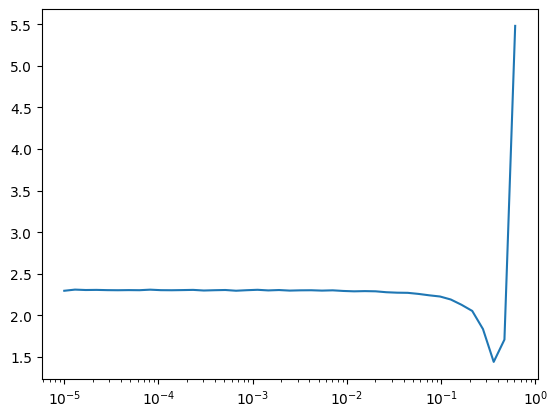

In [12]:
model = get_model()
model.apply(init_weights);
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

accuracy,loss,epoch,train
0.649,1.065,0,train
0.811,0.524,0,eval
0.831,0.460,1,train
0.840,0.427,1,eval
0.854,0.400,2,train
0.831,0.454,2,eval


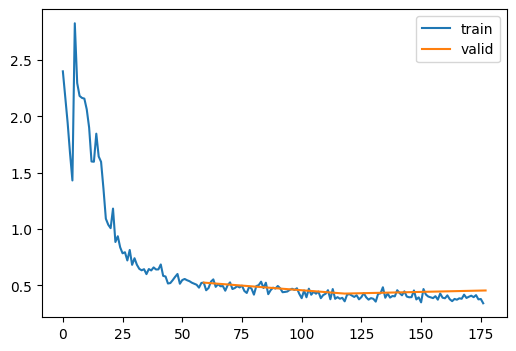

In [14]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.19, cbs=cbs)
learn.fit(3)

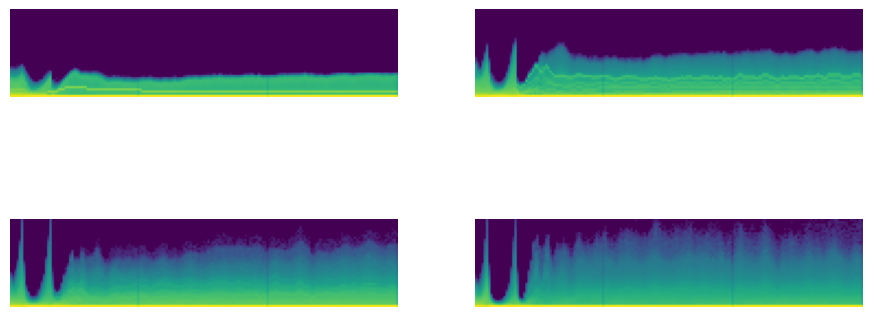

In [66]:
astats.color_dim()

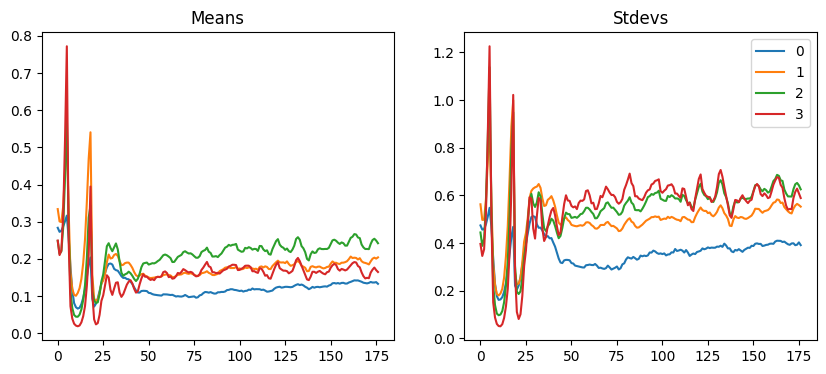

In [67]:
astats.plot_stats()

## Input normalisation

In [15]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd     

(tensor(0.29), tensor(0.35))

In [16]:
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_valid=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): learn.batch = self.tfm(learn.batch)

In [17]:
def _norm(b): return (b[0] - xmean) / xstd, b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.558,1.355,0,train
0.768,0.606,0,eval
0.814,0.504,1,train
0.820,0.482,1,eval
0.846,0.419,2,train
0.826,0.456,2,eval


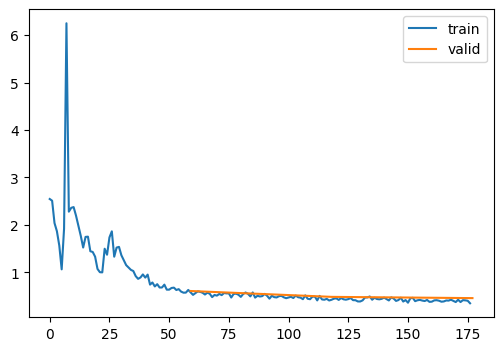

In [18]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

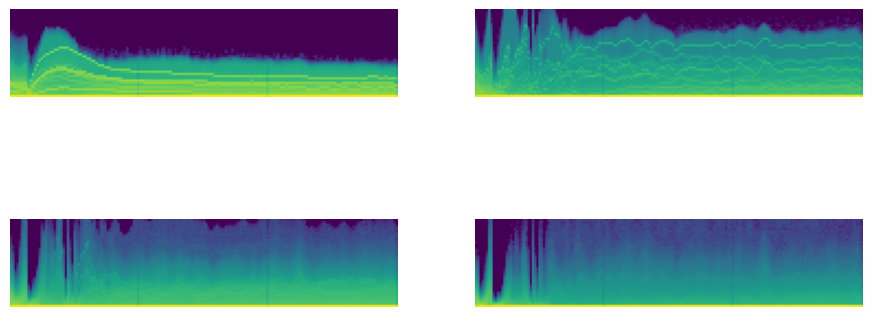

In [19]:
astats.color_dim()

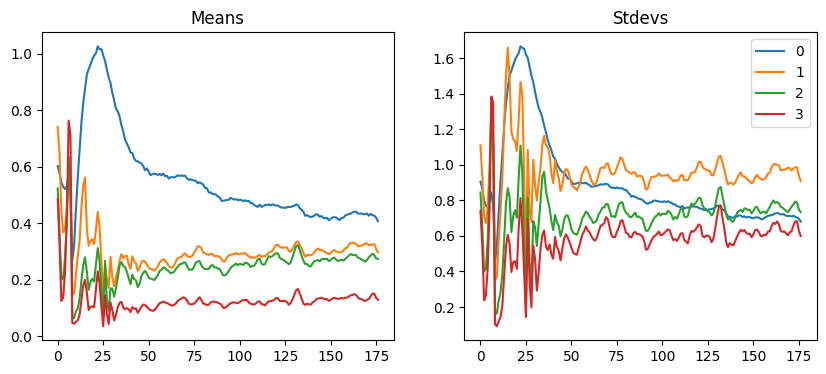

In [20]:
astats.plot_stats()

In [54]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [55]:
xb.mean(), xb.std()

(tensor(-0.01), tensor(0.99))

## General ReLU

In [56]:
class GeneralReLU(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else nn.ReLU(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_(self.maxv)
        return x

In [57]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

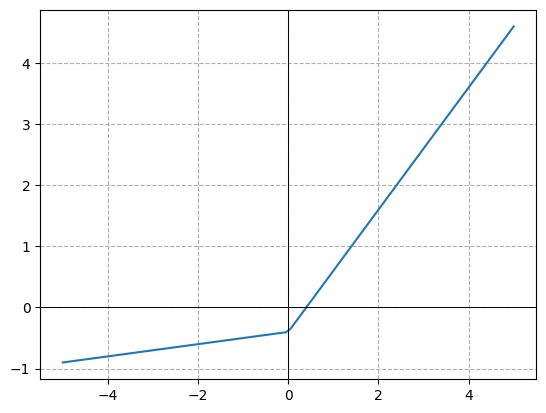

In [58]:
plot_func(GeneralReLU(leak=0.1, sub=0.4))

In [62]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [63]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs) -1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [64]:
# NB variable called `leaky` here but `leak` in GeneralReLU init. Keep as is to avoid bugs if forgotten but should have the same names!
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [65]:
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [66]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.762,0.672,0,train
0.840,0.445,0,eval
0.864,0.371,1,train
0.863,0.374,1,eval
0.881,0.324,2,train
0.867,0.356,2,eval


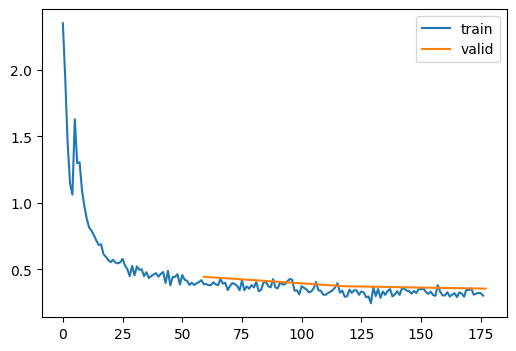

In [67]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

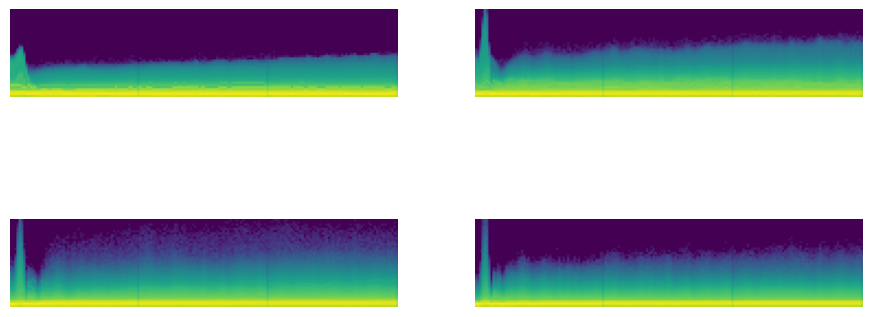

In [68]:
astats.color_dim()

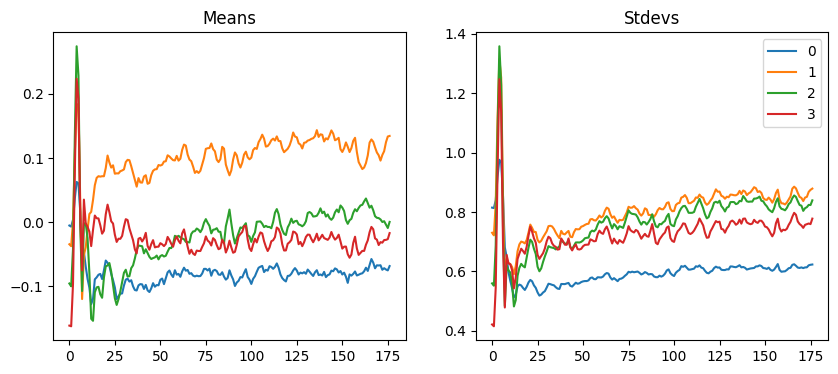

In [69]:
astats.plot_stats()

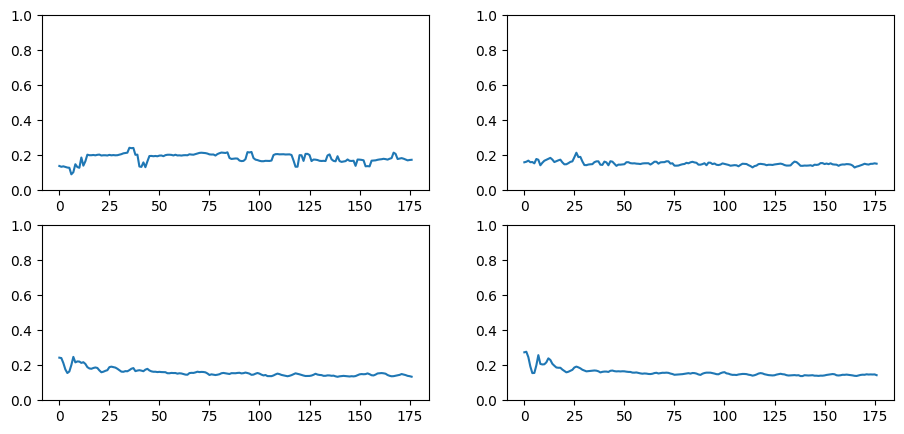

In [70]:
astats.dead_chart()